In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from dbscan_cluster import run_dbscan
from cluster_utils import cluster_plot, cluster_plot_galactic
import json

from astropy.coordinates import SkyCoord, ICRS
import astropy.units as u
from simbad_download import resolve_name
from uncertainties import unumpy, ufloat
from sklearn.preprocessing import StandardScaler

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
CLUSTER_NAME: str = 'NGC 2506'

In [3]:
gaiadr3 = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}.csv')
normalized = np.loadtxt(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_normalized.dat')
uncert = np.loadtxt(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_normalized_uncert.dat')
normalized_cp = np.loadtxt(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_normalized_cp.dat')
uncert_cp = np.loadtxt(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_normalized_cp_uncert.dat')
lit = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_literature.csv')

In [4]:
lit_dr3 = pd.merge(left=lit[['EDR3 id', 'reported', 'TIC']], right=gaiadr3, left_on='EDR3 id', right_on='source_id', how='inner')

In [5]:
cp_ra, cp_dec, cp_par, cp_pmra, cp_pmdec, cp_radvel = resolve_name(CLUSTER_NAME)

In [6]:
galactic_coords = SkyCoord(ra=cp_ra*u.deg, dec=cp_dec*u.deg,
                           pm_ra_cosdec=cp_pmra*u.mas/u.year, frame=ICRS,
                           pm_dec=cp_pmdec*u.mas/u.year).galactic

In [7]:
galactic_coords

<SkyCoord (Galactic): (l, b) in deg
    (230.5694282, 9.93815998)
 (pm_l_cosb, pm_b) in mas / yr
    (-4.67475711, -0.24582711)>

# Plain DBSCAN

In [8]:
clustered, noise, found, not_found = run_dbscan(normalized, gaiadr3, lit_dr3, 0.15, 2, False)

Classified into 691 labels.
Clustered: 977/1126
977/1126 sources from literature clustered
1589 clustered sources.


In [9]:
clustered_sets = []
noise_sets = []
found_sets = []
not_found_sets = []

for _ in range(50):
    normalized_u = normalized + np.random.normal(scale=np.abs(uncert), size=normalized.shape)
    clustered, noise, found, not_found = run_dbscan(normalized_u, gaiadr3, lit_dr3, 0.175, 2, False)
    clustered_sets.append(clustered)
    noise_sets.append(noise)
    found_sets.append(found)
    not_found_sets.append(not_found)

Classified into 549 labels.
Clustered: 948/1126
948/1126 sources from literature clustered
1266 clustered sources.
Classified into 583 labels.
Clustered: 949/1126
949/1126 sources from literature clustered
1300 clustered sources.
Classified into 577 labels.
Clustered: 942/1126
942/1126 sources from literature clustered
1291 clustered sources.
Classified into 556 labels.
Clustered: 967/1126
967/1126 sources from literature clustered
1326 clustered sources.
Classified into 578 labels.
Clustered: 949/1126
949/1126 sources from literature clustered
1269 clustered sources.
Classified into 560 labels.
Clustered: 967/1126
967/1126 sources from literature clustered
1321 clustered sources.
Classified into 567 labels.
Clustered: 964/1126
964/1126 sources from literature clustered
1306 clustered sources.
Classified into 578 labels.
Clustered: 949/1126
949/1126 sources from literature clustered
1275 clustered sources.
Classified into 574 labels.
Clustered: 982/1126
982/1126 sources from literature

In [10]:
clustered = pd.concat(clustered_sets).drop_duplicates(subset=['source_id'])
len(clustered)

2104

In [11]:
found = pd.concat(found_sets).drop_duplicates(subset=['source_id'])

In [12]:
not_found = pd.concat(not_found_sets).drop_duplicates(subset=['source_id'])

In [13]:
clustered.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,A_y,A_J,A_H,A_K,BP-RP,BP-RP_error,G_abs,G_abs_error,excess,label
1985,1636148068921376768,Gaia DR3 3037977913478488064,3037977913478488064,300090005,2016.0,120.069014,0.051681,-11.187358,0.043851,0.255903,...,0.352377,0.221163,0.130851,0.084425,0.669643,0.008318,3.90591,0.575535,0.002447,50
2277,1636148068921376768,Gaia DR3 3037983136158747648,3037983136158747648,1702076861,2016.0,119.961597,0.017269,-11.09187,0.013302,0.251084,...,0.274071,0.172016,0.101773,0.065664,0.581987,0.001934,1.479225,0.185546,0.006257,50
2316,1636148068921376768,Gaia DR3 3037983582835325056,3037983582835325056,978951834,2016.0,119.967136,0.023988,-11.041966,0.018858,0.288149,...,0.195765,0.122868,0.072695,0.046903,0.542625,0.002872,2.579758,0.229467,0.001658,50
2364,1636148068921376768,Gaia DR3 3037984270029993344,3037984270029993344,737845908,2016.0,120.104531,0.024153,-11.050122,0.018883,0.212574,...,0.234918,0.147442,0.087234,0.056284,0.568348,0.002294,1.879718,0.324439,0.005057,50
2377,1636148068921376768,Gaia DR3 3037984441828696832,3037984441828696832,935186244,2016.0,120.080582,0.02557,-11.035086,0.019524,0.345745,...,0.352377,0.221163,0.130851,0.084425,0.476482,0.002922,2.999165,0.21456,0.007774,50


In [18]:
occurences = clustered['source_id'].apply(lambda x:
                                          sum([len(np.intersect1d(cs.source_id.values, [x])) for cs in clustered_sets]))

In [14]:
found['occurences'] = found['source_id'].apply(lambda x:
                                          sum([len(np.intersect1d(cs.source_id.values, [x])) for cs in found_sets]))/50.0

In [15]:
not_found['occurences'] = 1.0-not_found['source_id'].apply(lambda x:
                                                       sum([len(np.intersect1d(cs.source_id.values, [x])) for cs in not_found_sets]))/50.0

In [19]:
clustered['occurences'] = occurences/50.0
clustered.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,A_J,A_H,A_K,BP-RP,BP-RP_error,G_abs,G_abs_error,excess,label,occurences
1985,1636148068921376768,Gaia DR3 3037977913478488064,3037977913478488064,300090005,2016.0,120.069014,0.051681,-11.187358,0.043851,0.255903,...,0.221163,0.130851,0.084425,0.669643,0.008318,3.90591,0.575535,0.002447,50,0.02
2277,1636148068921376768,Gaia DR3 3037983136158747648,3037983136158747648,1702076861,2016.0,119.961597,0.017269,-11.09187,0.013302,0.251084,...,0.172016,0.101773,0.065664,0.581987,0.001934,1.479225,0.185546,0.006257,50,0.06
2316,1636148068921376768,Gaia DR3 3037983582835325056,3037983582835325056,978951834,2016.0,119.967136,0.023988,-11.041966,0.018858,0.288149,...,0.122868,0.072695,0.046903,0.542625,0.002872,2.579758,0.229467,0.001658,50,0.54
2364,1636148068921376768,Gaia DR3 3037984270029993344,3037984270029993344,737845908,2016.0,120.104531,0.024153,-11.050122,0.018883,0.212574,...,0.147442,0.087234,0.056284,0.568348,0.002294,1.879718,0.324439,0.005057,50,0.16
2377,1636148068921376768,Gaia DR3 3037984441828696832,3037984441828696832,935186244,2016.0,120.080582,0.02557,-11.035086,0.019524,0.345745,...,0.221163,0.130851,0.084425,0.476482,0.002922,2.999165,0.21456,0.007774,50,0.30


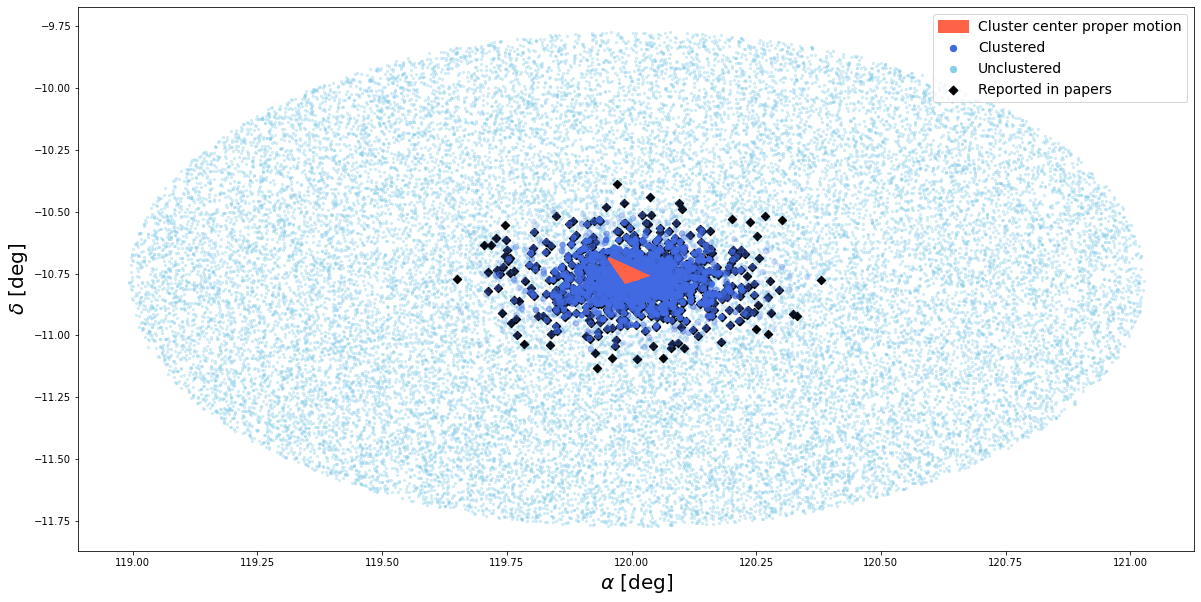

In [21]:
plt.figure(figsize=(20, 10))
plt.scatter(clustered.ra, clustered.dec, 
            color='royalblue', alpha=clustered.occurences, label='Clustered', zorder=2, s=30.)
plt.scatter(noise.ra, noise.dec, color='skyblue', label='Unclustered', zorder=1, s=5., alpha=.3)
plt.scatter(lit_dr3.ra, lit_dr3.dec, color='black', zorder=1,
            marker='D', label='Reported in papers')

plt.gca().set_xlabel('$\\alpha$ [deg]', fontsize=20);
plt.gca().set_ylabel('$\delta$ [deg]', fontsize=20);


plt.arrow(cp_ra,
          cp_dec,
          cp_pmra*(u.arcsec/u.year).to(u.deg/u.year),
          cp_pmdec*(u.arcsec/u.year).to(u.deg/u.year),
          linewidth=3.,
          color='tomato',
          head_width=0.05,
          head_length=0.1,
          zorder=4, label='Cluster center proper motion')

lgnd = plt.legend(fontsize=14, loc='upper right');
for handle in lgnd.legendHandles:
    handle._sizes = [40];
    handle._alpha = 1.;

In [22]:
clustered.to_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_clustered.csv')
found.to_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_found.csv')
not_found.to_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_not_found.csv')

# Convergent velocities

In [13]:
with open(f'optuna_db/{CLUSTER_NAME}/{CLUSTER_NAME.replace(" ", "_")}_cp_best_params.json', 'r') as f:
    best_params = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'optuna_db/NGC 188/NGC_188_cp_best_params.json'

In [ ]:
best_params

In [28]:
clustered, noise, found, not_found = run_dbscan(normalized_cp, gaiadr3, lit_dr3, 0.025, 25, False)

Classified into 51 labels.
Clustered: 724/957
724/957 sources from literature clustered
1384 clustered sources.


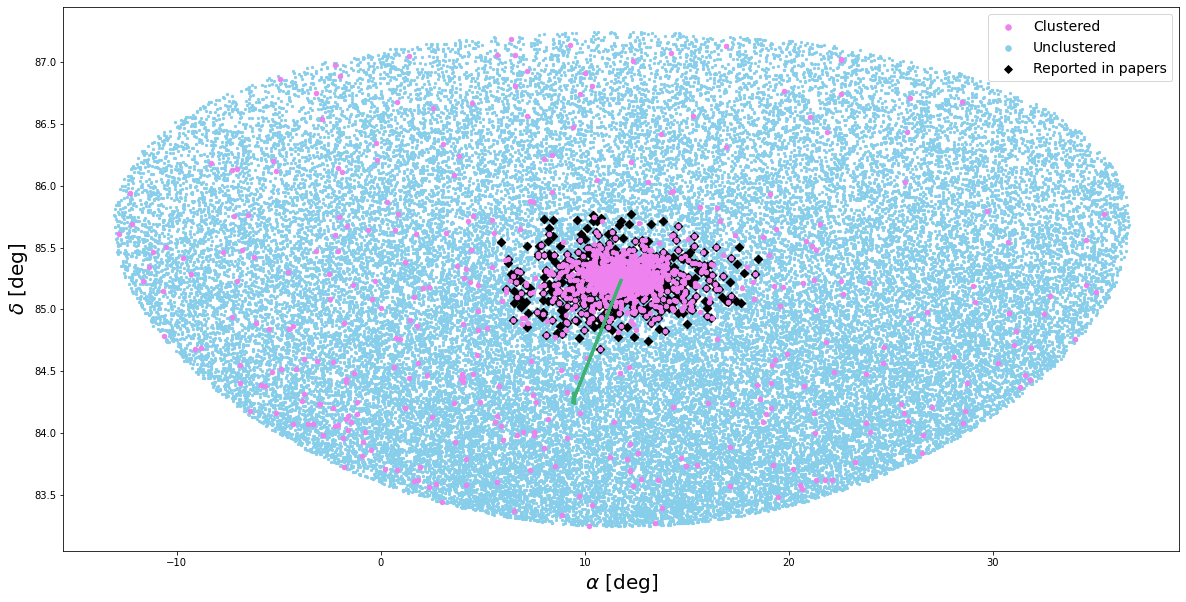

In [29]:
cluster_plot(clustered, gaiadr3, lit_dr3)
plt.arrow(cp_ra,
          cp_dec,
          cp_pmra,
          cp_pmdec,
          linewidth=3.,
          color='mediumseagreen',
          head_width=0.1,
          head_length=0.1,
          zorder=4)

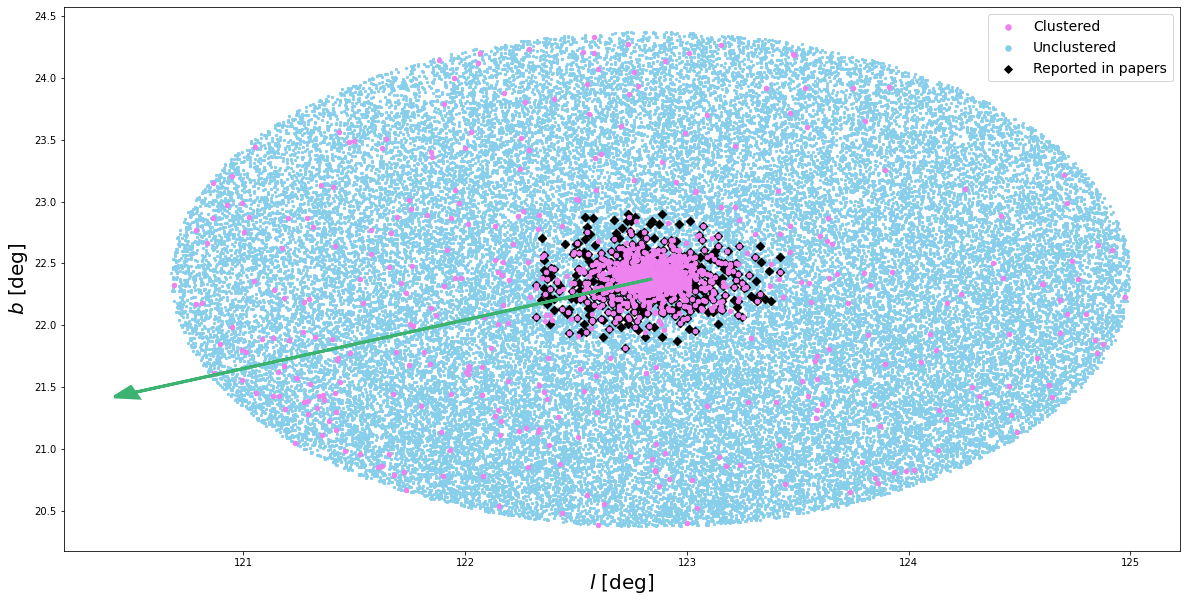

In [30]:
cluster_plot_galactic(clustered, gaiadr3, lit_dr3)
plt.arrow(galactic_coords.l.value,
          galactic_coords.b.value,
          galactic_coords.pm_l_cosb.value,
          galactic_coords.pm_b.value,
          linewidth=3.,
          color='mediumseagreen',
          head_width=0.1,
          head_length=0.1,
          zorder=4)

In [ ]:
a = np.loadtxt('Trumpler 5_isochrone.dat', usecols=(28, 29, 30))

In [ ]:
plt.plot(a[:-1, 1]-a[:-1, 2], a[:-1, 0])
plt.gca().invert_yaxis();